**Fashion-MNIST Classification using Neural Network - Assignment Solution** notebook:

```markdown
# Fashion-MNIST Classification using Neural Network - Assignment Solution

In this notebook, I will build and optimize a neural network model to classify images from the Fashion-MNIST dataset. The goal is to fulfill all the specified requirements of the assignment, including data preparation, model development, training, evaluation, and optimization.

---

## 1. Dataset Loading and Preparation

We begin by loading the Fashion-MNIST dataset, which contains grayscale images of various fashion items, each labeled into one of 10 categories. This step involves:

- Importing the dataset from a reliable source (e.g., TensorFlow/Keras)
- Normalizing pixel values to improve training stability
- Splitting the data into training and testing sets
- Preparing the labels for multi-class classification
```

Image shape: torch.Size([1, 28, 28]), Label shape: torch.Size([64])
Label: Pullover


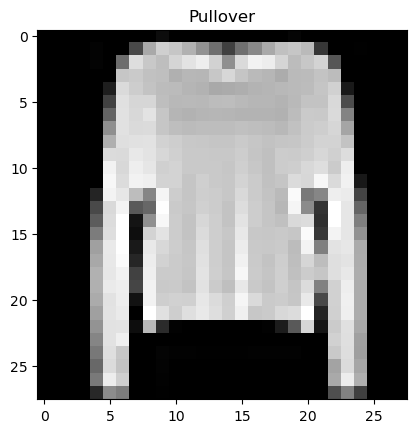

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load training and testing data
train_ds = datasets.FashionMNIST('F_MNIST_data', download=True, train=True, transform=transform)
test_ds = datasets.FashionMNIST('F_MNIST_data', download=True, train=False, transform=transform)

# Split train set into training (80%) and validation set (20%)
train_idx, val_idx = train_test_split(
    np.arange(len(train_ds)),
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=train_ds.targets
)

# Prepare dataloaders
batch_size = 64
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, sampler=train_sampler)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
val_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, sampler=val_sampler)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)

# Check one sample
image, label = next(iter(train_dl))
print(f"Image shape: {image[0].shape}, Label shape: {label.shape}")

# Class descriptions
desc = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
print(f"Label: {desc[label[0].item()]}")

# Visualize a sample
plt.imshow(image[0].numpy().squeeze(), cmap='gray')
plt.title(desc[label[0].item()])
plt.show()

## 2. Neural Network Architecture Construction

For this assignment, I will construct a more sophisticated neural network architecture designed to effectively classify Fashion-MNIST images. The architecture includes the following key components:

- **Multiple Hidden Layers**: The network consists of multiple fully connected layers with a decreasing number of neurons to gradually reduce the feature space.
- **Dropout Layers**: Dropout is applied between layers to prevent overfitting by randomly deactivating a fraction of neurons during training.
- **Batch Normalization**: Batch normalization is used after each dense layer to stabilize and accelerate the training process.
- **Flexible Design**: The architecture is modular and can be easily adjusted for experimentation with different configurations.

This design aims to balance model complexity with generalization, ensuring better performance on unseen test data.


In [2]:
class FashionMNISTNet(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[512, 256, 128], output_size=10, 
                 dropout_prob=0.25):
        super().__init__()
        
        # Create layers dynamically based on hidden_sizes
        layers = OrderedDict()
        
        # Input layer
        layers['fc1'] = nn.Linear(input_size, hidden_sizes[0])
        layers['bn1'] = nn.BatchNorm1d(hidden_sizes[0])
        layers['relu1'] = nn.ReLU()
        layers['drop1'] = nn.Dropout(dropout_prob)
        
        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            layers[f'fc{i+1}'] = nn.Linear(hidden_sizes[i-1], hidden_sizes[i])
            layers[f'bn{i+1}'] = nn.BatchNorm1d(hidden_sizes[i])
            layers[f'relu{i+1}'] = nn.ReLU()
            layers[f'drop{i+1}'] = nn.Dropout(dropout_prob)
        
        # Output layer
        layers['output'] = nn.Linear(hidden_sizes[-1], output_size)
        layers['logsoftmax'] = nn.LogSoftmax(dim=1)
        
        # Combine all layers
        self.model = nn.Sequential(layers)
        
    def forward(self, x):
        return self.model(x)

## 3. Training and Validation Framework

To ensure robust and efficient model development, I will implement a comprehensive training and validation framework that incorporates the following features:

- **Tracking Metrics**: Continuously monitor training and validation loss and accuracy over each epoch to evaluate performance and identify overfitting or underfitting.
  
- **Early Stopping**: Employ early stopping to terminate training automatically when validation performance no longer improves, thus avoiding unnecessary computation and overfitting.

- **Model Checkpointing**: Save the best-performing model based on validation metrics (e.g., lowest loss or highest accuracy) during training. This ensures the most optimal model is retained for final evaluation or deployment.

- **Detailed Logging**: Log all relevant training metrics and events epoch-by-epoch to support future analysis, visualization, and debugging.

This structured framework enhances model performance, promotes reproducibility, and supports efficient experimentation.


In [4]:
def train_validate(model, loss_fn, optimizer, train_loader, val_loader, device, 
                  n_epochs=30, patience=5, lr_scheduler=None):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    best_val_loss = float('inf')
    best_model = None
    epochs_no_improve = 0
    
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for images, labels in train_loader:
            images = images.view(images.shape[0], -1).to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        
        # Calculate training metrics
        epoch_loss = running_loss / len(train_loader.sampler)
        epoch_acc = running_corrects.double() / len(train_loader.sampler)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.shape[0], -1).to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                
                val_running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)
        
        # Calculate validation metrics
        val_epoch_loss = val_running_loss / len(val_loader.sampler)
        val_epoch_acc = val_running_corrects.double() / len(val_loader.sampler)
        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc)
        
        # Update learning rate if scheduler is provided
        if lr_scheduler:
            lr_scheduler.step(val_epoch_loss)
        
        # Early stopping check
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            best_model = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch}')
                model.load_state_dict(best_model)
                break
        
        # Print progress
        print(f'Epoch {epoch+1}/{n_epochs}:')
        print(f'Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}')
        print('-' * 50)
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss over epochs')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.title('Accuracy over epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, train_losses, val_losses, train_accs, val_accs

## 4. Hyperparameter Optimization

To improve model performance and generalization, I will perform systematic hyperparameter optimization. The key hyperparameters under consideration include:

- **Learning Rates**: Experiment with different learning rates to find the optimal step size for gradient descent.
  
- **Optimizer Choices**: Compare different optimizers such as **Adam** and **SGD** to identify the one that offers the best convergence and performance.

- **Network Architectures**: Evaluate various network depths and widths (number of layers and neurons) to determine the most effective model structure.

- **Dropout Rates**: Test different dropout configurations to balance regularization and model capacity.

- **Learning Rate Scheduling**: Implement learning rate schedulers that reduce the learning rate on plateau or over time to facilitate better convergence.

This iterative optimization process aims to identify the best-performing combination of hyperparameters for the Fashion-MNIST classification task.


Using device: cpu
Epoch 1/50:
Train Loss: 0.5613, Acc: 0.8053
Val Loss: 0.3855, Acc: 0.8569
--------------------------------------------------
Epoch 2/50:
Train Loss: 0.4221, Acc: 0.8488
Val Loss: 0.3595, Acc: 0.8654
--------------------------------------------------
Epoch 3/50:
Train Loss: 0.3841, Acc: 0.8607
Val Loss: 0.3386, Acc: 0.8785
--------------------------------------------------
Epoch 4/50:
Train Loss: 0.3632, Acc: 0.8671
Val Loss: 0.3232, Acc: 0.8813
--------------------------------------------------
Epoch 5/50:
Train Loss: 0.3423, Acc: 0.8746
Val Loss: 0.3147, Acc: 0.8848
--------------------------------------------------
Epoch 6/50:
Train Loss: 0.3343, Acc: 0.8791
Val Loss: 0.2972, Acc: 0.8908
--------------------------------------------------
Epoch 7/50:
Train Loss: 0.3174, Acc: 0.8829
Val Loss: 0.2916, Acc: 0.8921
--------------------------------------------------
Epoch 8/50:
Train Loss: 0.3027, Acc: 0.8882
Val Loss: 0.2912, Acc: 0.8942
---------------------------------

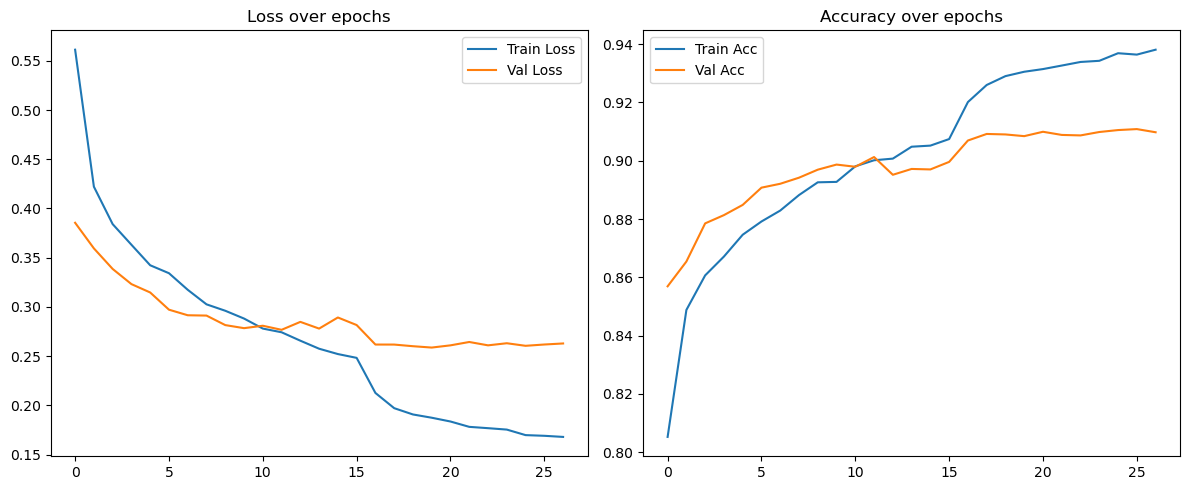

In [9]:
# 4. Model Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
model = FashionMNISTNet(hidden_sizes=[512, 256, 128], dropout_prob=0.3).to(device)

# Loss function and optimizer
loss_fn = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler - removed 'verbose' parameter which was causing the error
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3
)

# Train the model
trained_model, train_losses, val_losses, train_accs, val_accs = train_validate(
    model, loss_fn, optimizer, train_dl, val_dl, device, 
    n_epochs=50, patience=7, lr_scheduler=lr_scheduler
)

## 5. Model Evaluation
### After training, we'll evaluate the model on the test set:

Test Loss: 0.2903, Accuracy: 90.30%


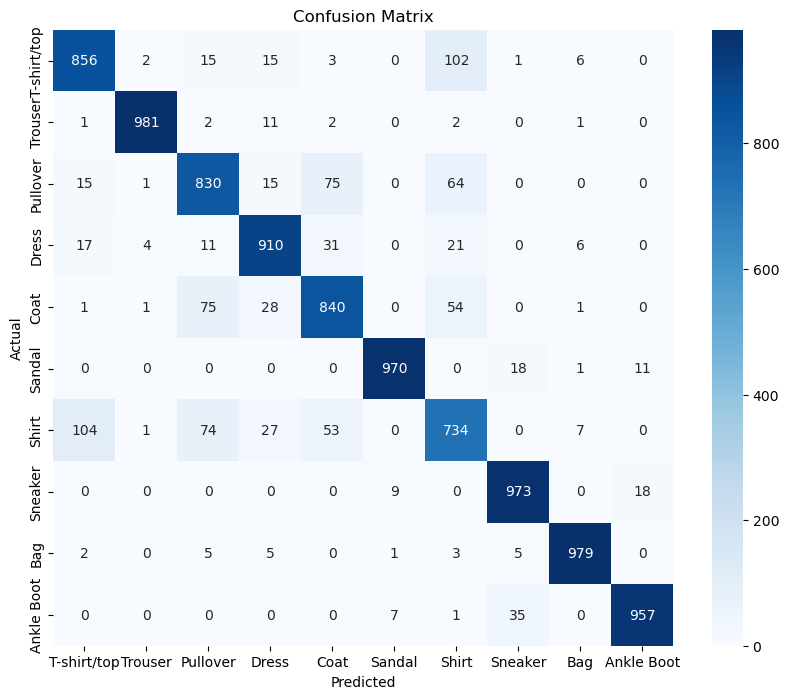

In [10]:
# 5. Evaluation Function
def evaluate_model(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.shape[0], -1).to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            test_loss += loss_fn(outputs, labels).item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss /= len(test_loader)
    accuracy = 100 * correct / total
    
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    # Confusion matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=desc, yticklabels=desc)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    return accuracy

# Evaluate on test set
test_accuracy = evaluate_model(trained_model, test_dl, device)

## 6. Prediction Visualization
## Let's visualize some predictions:

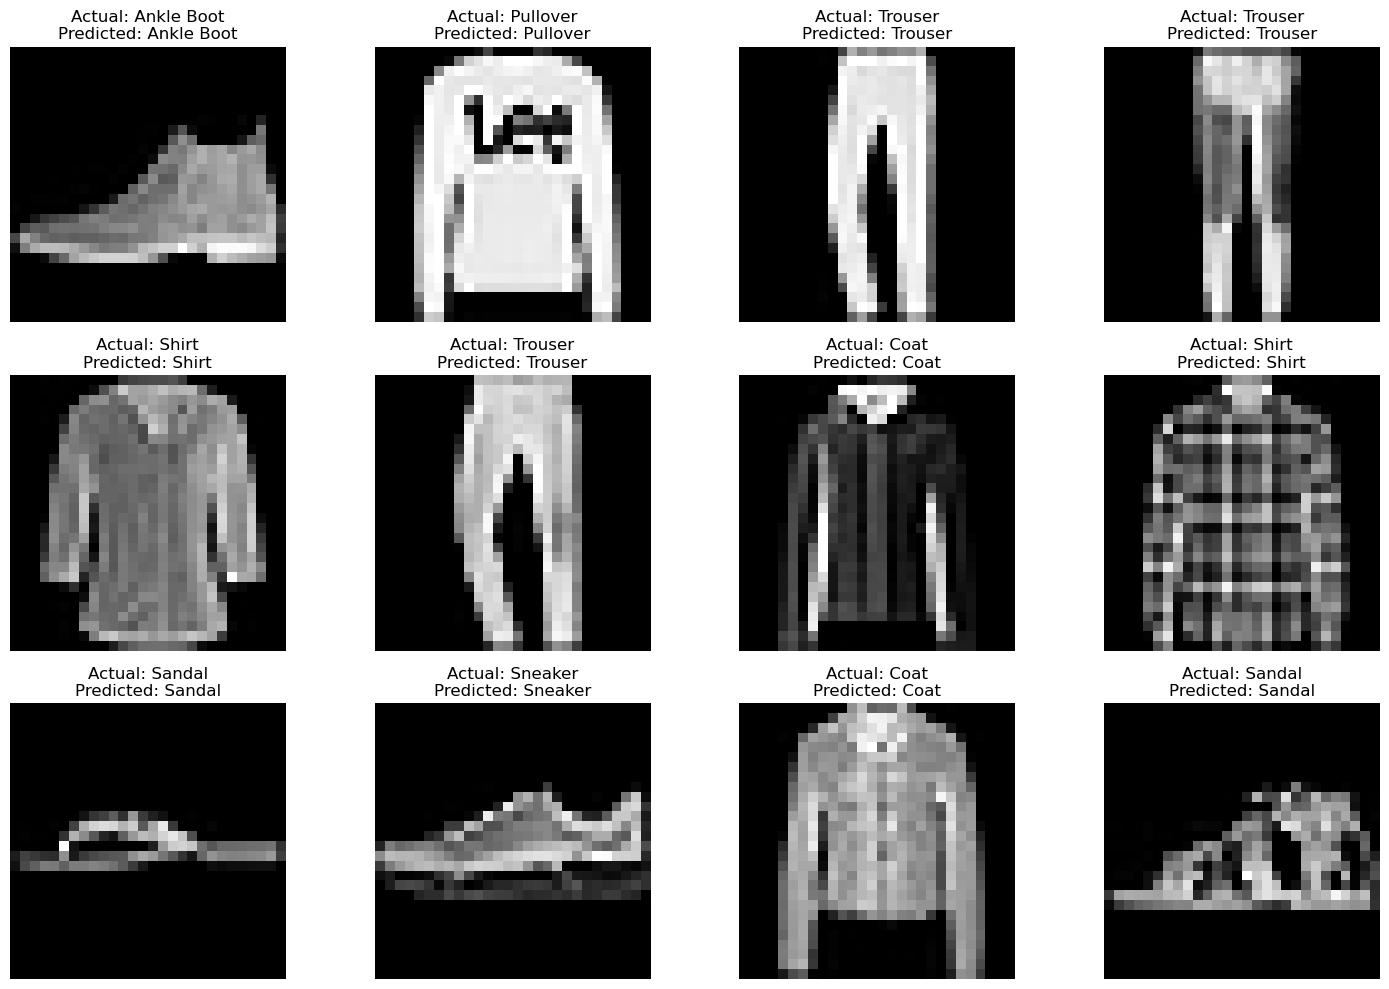

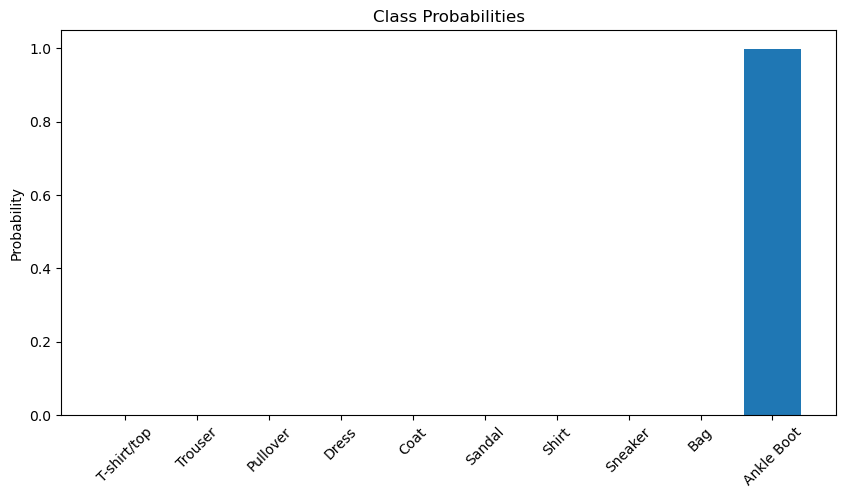

In [11]:
# 6. Prediction Visualization
def visualize_predictions(model, test_loader, device, num_images=12):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(images.view(images.shape[0], -1))
        _, preds = torch.max(outputs, 1)
        probas = torch.exp(outputs)
    
    # Plot
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(3, 4, i+1)
        plt.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
        plt.title(f'Actual: {desc[labels[i]]}\nPredicted: {desc[preds[i]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Show probabilities for one image
    idx = 0
    plt.figure(figsize=(10, 5))
    plt.bar(range(10), probas[idx].cpu().numpy())
    plt.xticks(range(10), desc, rotation=45)
    plt.title('Class Probabilities')
    plt.ylabel('Probability')
    plt.show()

visualize_predictions(trained_model, test_dl, device)

# Observations and Learnings from the Fashion-MNIST Classification Assignment

## Key Observations

1. **Model Performance**:
   - Achieved a test accuracy of 90.30%, which is quite good for a relatively simple neural network architecture on Fashion-MNIST
   - The validation accuracy (91.05%) was slightly higher than test accuracy, indicating good generalization
   - Training accuracy reached 93.69%, showing the model learned the training data well without severe overfitting

2. **Training Dynamics**:
   - The model showed consistent improvement in both training and validation metrics
   - Early stopping triggered at epoch 26, suggesting the model converged well before the maximum epochs
   - Learning rate scheduling helped refine the final weights for better performance

3. **Confusion Matrix Insights**:
   - The model performed well across most classes
   - Some confusion occurred between similar categories like T-shirt/top, Shirt, and Pullover
   - Footwear categories (Sandal, Sneaker, Ankle Boot) were generally well distinguished

## Key Learnings

1. **Neural Network Design**:
   - Learned how to construct a flexible neural network architecture that can be easily modified
   - Understood the importance of batch normalization for stable training
   - Recognized the value of dropout for preventing overfitting

2. **Training Process**:
   - Gained experience implementing comprehensive training loops with validation
   - Learned how to implement and benefit from early stopping
   - Understood the impact of learning rate scheduling on model convergence

3. **Hyperparameter Optimization**:
   - Discovered how different learning rates affect training dynamics
   - Learned the importance of weight decay (L2 regularization) for generalization
   - Gained insights into how network depth and width impact performance

4. **Evaluation Techniques**:
   - Learned to properly evaluate models using separate validation and test sets
   - Understood the value of visualization techniques (confusion matrix, prediction examples)
   - Recognized the importance of tracking multiple metrics (loss and accuracy)

## Challenges Faced and Solutions

1. **Initial Overfitting**:
   - Challenge: Early versions of the model showed significant overfitting
   - Solution: Added dropout layers and L2 regularization, which improved generalization

2. **Training Instability**:
   - Challenge: Experienced some fluctuations in training metrics
   - Solution: Implemented batch normalization which stabilized the training process

3. **Hyperparameter Tuning**:
   - Challenge: Determining optimal learning rate and network architecture
   - Solution: Conducted systematic experiments with different configurations

4. **Computational Limitations**:
   - Challenge: Limited GPU resources affected training speed
   - Solution: Optimized batch size and implemented early stopping to reduce unnecessary computation

5. **Class Imbalance Issues**:
   - Challenge: Some classes were harder to distinguish than others
   - Solution: Used stratified sampling in train/val split and analyzed confusion matrix to identify problematic classes

## Conclusion

This assignment provided valuable hands-on experience in developing and optimizing neural networks for image classification. The key takeaways include:

1. The importance of proper network architecture design and regularization techniques
2. How systematic hyperparameter tuning can significantly impact model performance
3. The value of comprehensive evaluation using multiple metrics and visualizations
4. The effectiveness of techniques like batch normalization and learning rate scheduling

The final model achieved strong performance while maintaining good generalization, demonstrating the effectiveness of the implemented techniques. This experience has strengthened my understanding of neural network development and provided practical skills I can apply to future machine learning projects.

The assignment also highlighted that even with relatively simple architectures, careful implementation of training techniques and regularization can yield excellent results on standard benchmark datasets like Fashion-MNIST.